## GTA游戏AI识别车道分割线

* 1.读取与显示图像
* 2.探测边界
* 3.颜色提取
* 4.提取道路分割线


- https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/
- https://www.pyimagesearch.com/2017/09/11/object-detection-with-deep-learning-and-opencv/

### 1.读取与显示图像

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from random import shuffle
import matplotlib.pyplot as plt
import cv2
from numpy import ones,vstack
from numpy.linalg import lstsq
from statistics import mean

%matplotlib inline

* 读取图像

In [2]:
train_data = np.load('./data/training_data-1.npy')
df = pd.DataFrame(train_data)
print(df.head())
print(Counter(df[1].apply(str)))

                                                   0  \
0  [[[238, 204, 171], [246, 231, 216], [69, 55, 4...   
1  [[[238, 204, 171], [246, 231, 216], [69, 57, 4...   
2  [[[238, 204, 171], [246, 231, 216], [69, 55, 4...   
3  [[[238, 204, 171], [246, 231, 216], [63, 51, 3...   
4  [[[238, 204, 171], [246, 231, 216], [91, 90, 8...   

                             1  
0  [1, 0, 0, 0, 0, 0, 0, 0, 0]  
1  [1, 0, 0, 0, 0, 0, 0, 0, 0]  
2  [0, 0, 0, 0, 1, 0, 0, 0, 0]  
3  [0, 0, 0, 0, 0, 1, 0, 0, 0]  
4  [0, 0, 0, 0, 1, 0, 0, 0, 0]  
Counter({'[1, 0, 0, 0, 0, 0, 0, 0, 0]': 177, '[0, 0, 0, 0, 0, 1, 0, 0, 0]': 163, '[0, 0, 0, 0, 0, 0, 0, 0, 0]': 148, '[0, 0, 0, 0, 1, 0, 0, 0, 0]': 69, '[0, 0, 1, 0, 0, 0, 0, 0, 0]': 41, '[0, 0, 0, 1, 0, 0, 0, 0, 0]': 13, '[0, 0, 0, 0, 0, 0, 0, 1, 0]': 1})


In [3]:
# key_map = {
#     'W': [1, 0, 0, 0, 0, 0, 0, 0, 0],
#     'S': [0, 1, 0, 0, 0, 0, 0, 0, 0],
#     'A': [0, 0, 1, 0, 0, 0, 0, 0, 0],
#     'D': [0, 0, 0, 1, 0, 0, 0, 0, 0],
#     'WA': [0, 0, 0, 0, 1, 0, 0, 0, 0],
#     'WD': [0, 0, 0, 0, 0, 1, 0, 0, 0],
#     'SA': [0, 0, 0, 0, 0, 0, 1, 0, 0],
#     'SD': [0, 0, 0, 0, 0, 0, 0, 1, 0],
#     'NK': [0, 0, 0, 0, 0, 0, 0, 0, 1],
#     'default': [0, 0, 0, 0, 0, 0, 0, 0, 0],
# }

* 显示图像

In [4]:
def show_saved_data(idx):
    plt.figure()
    plt.axis("off")
    #since matplotlib diplay picture in RGB, we need to convert to rgb
    rgb_img = cv2.cvtColor(train_data[idx][0], cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(rgb_img)
    print(train_data[idx][1])

def get_rgb_img(img, title=None):
    plt.figure()
    
    plt.axis("off")
    #since matplotlib diplay picture in RGB, we need to convert to rgb
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if title:
        plt.title(title)
    imgplot = plt.imshow(rgb_img)
    return rgb_img

def show_rgb_img(img, title=None):
    get_rgb_img(img, title)

def show_raw_img(img, title=None):
    plt.figure()
    plt.axis("off")
    if title:
        plt.title(title)
    imgplot = plt.imshow(img)
    #plt.colorbar()  

def get_saved_data(idx):
    return train_data[idx][0].copy(),train_data[idx][1].copy()

[1, 0, 0, 0, 0, 0, 0, 0, 0]


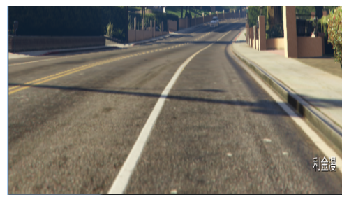

In [5]:
show_saved_data(1)

In [6]:
def roi(img, vertices): #region of interest: i.e. cropping image
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked = cv2.bitwise_and(img, mask)
    return masked

In [7]:
#Input lines format: e.g. "[[[104, 112, 346, 133]],[[129, 269, 479, 269]],[[1, 117,  51, 104]]]..." (note: this format is output from cv2.HoughLinesP function)
def draw_lines(img,lines,color=[255,255,255],width=8):
    for line in lines:
        coords = line[0]
        cv2.line(img, (coords[0], coords[1]), (coords[2], coords[3]), [255,255,255], 8)

## 2.探测边界 (Edge Detection)

Note: HoughLinesP is the key function to detect lines from img

Principle: https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

Function: https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb

In [8]:
#https://henrydangprg.com/2016/12/11/canny-edge-detection-in-python-with-opencv/
def detect_edge(rgb_image):
    gray_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)   
    #processed_img = cv2.Canny(rgb_image, threshold1=200, threshold2=300)
    #processed_img = cv2.Canny(gray_img, threshold1=130, threshold2=226)
    processed_img = cv2.Canny(gray_img, threshold1=48, threshold2=338)    
    processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )
    #vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)
    #processed_img = roi(processed_img, [vertices])
    #plt.imshow(processed_img)    
    
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)
    #print(lines)
    #draw_lines(processed_img,lines)    
    return processed_img, lines

In [9]:
def display_image_win(pos,img):
    cv2.imshow(pos, img)

def destroy_win():    
    while True:
        #if cv2.waitKey(25) & 0xFF == ord('q'):
        if cv2.waitKey(0) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

In [10]:
img, action = get_saved_data(1)

In [11]:
display_image_win('window',img)
new_screen, hlines= detect_edge(img)
display_image_win('window2',new_screen)

draw_lines(new_screen,hlines) # it will make change on the original lines, but not return any new img
display_image_win('window3',new_screen)
destroy_win()

In [12]:
new_screen.shape

(270, 480)

## 3.颜色提取color exctraction

In [17]:
#https://docs.opencv.org/master/df/d9d/tutorial_py_colorspaces.html
#https://stackoverflow.com/questions/21737613/image-of-hsv-color-wheel-for-opencv
org_img = train_data[1][0]
while(1):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(org_img, cv2.COLOR_BGR2HSV)

    # define range of yellow color in HSV
    lower_yellow = np.array([15, 100, 100])
    upper_yellow = np.array([45,255,255])

    lower_white = np.array([0, 0, 0])
    upper_white = np.array([100,0,255])
    
    
    
    # Threshold the HSV image to get only blue colors
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    # Bitwise-AND mask and original image
    res_yellow = cv2.bitwise_and(org_img,org_img, mask= yellow_mask)
    res1_white = cv2.bitwise_and(org_img,org_img, mask= white_mask)
    cv2.imshow('org',org_img)
    cv2.imshow('yellow_mask',yellow_mask)
    cv2.imshow('yellow',res_yellow)
    cv2.imshow('white',res1_white)
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

In [19]:
org_img = train_data[1][0]
#while(1):

#make above code into a function, for extraction of yellow
def extract_with_yellowBGR(org_img):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(org_img, cv2.COLOR_BGR2HSV)

    # define range of yellow color in HSV
    lower_yellow = np.array([15, 100, 100])
    upper_yellow = np.array([45,255,255])

    lower_white = np.array([0, 0, 0])
    upper_white = np.array([100,0,255])



    # Threshold the HSV image to get only blue colors
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # Bitwise-AND mask and original image
    res_yellow = cv2.bitwise_and(org_img,org_img, mask= yellow_mask)
    res1_white = cv2.bitwise_and(org_img,org_img, mask= white_mask)
    
    return res_yellow



Combination of Color Extraction and Edge Detection:

In [45]:
#Step1: extraction yellow component only from original picture
org_img = train_data[1][0]
res_yellow=extract_with_yellowBGR(org_img)
display_image_win('yellow',res_yellow)
destroy_win()

In [46]:
#Step2: color extraction above 把黄色的先extract出来后，然后use below code to extract edge (line)
yellow_edge_img,yellow_edge_line = detect_edge(res_yellow)
display_image_win('original',res_yellow)
draw_lines(yellow_edge_img,yellow_edge_line)
display_image_win('detect_edge',yellow_edge_img)
destroy_win()

In [23]:
yellow_edge_line

array([[[ 26, 110, 112,  90]],

       [[ 26, 111, 105,  93]]], dtype=int32)

In [24]:
# Make Step 1 and 2 into the below function:
def find_yellow_lane_BGR(org_img):
    """return a list of yellow lanes"""
    
    res_yellow=extract_with_yellowBGR(org_img)
    yellow_edge_img,yellow_edge_lines = detect_edge(res_yellow)
    return yellow_edge_lines

In [25]:
org_img = train_data[1][0]
find_yellow_lane_BGR(org_img)

array([[[ 26, 110, 112,  90]],

       [[ 26, 111, 105,  93]]], dtype=int32)

We can directly jump to Section 4.探测道路分割线 below from here

## color clustering (Optional: Did not cover in course)
- https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/

In [26]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist

In [27]:
def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX
    # return the bar chart
    return bar

In [28]:
from sklearn.cluster import KMeans

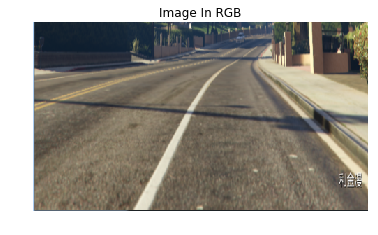

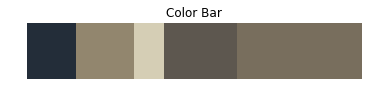

In [29]:
org_img = train_data[1][0]
rgb_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
show_raw_img(rgb_img,'Image In RGB')

shaped_image = rgb_img.reshape((rgb_img.shape[0] * rgb_img.shape[1], 3))

clt = KMeans(n_clusters = 5)
clt.fit(shaped_image)
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

# show our color bart
show_raw_img(bar,'Color Bar')

https://blog.danielparker.com.au/background-colour-detection-using-opencv-and-python-22ed8655b243

In [28]:
## counter most_common 


https://github.com/python/cpython/blob/3.6/Lib/heapq.py


In [27]:
def most_common(self, n=None):
    '''List the n most common elements and their counts from the most
    common to the least.  If n is None, then list all element counts.
    >>> Counter('abcdeabcdabcaba').most_common(3)
    [('a', 5), ('b', 4), ('c', 3)]
    '''
    # Emulate Bag.sortedByCount from Smalltalk
    if n is None:
        return sorted(self.iteritems(), key=_itemgetter(1), reverse=True)
    return _heapq.nlargest(n, self.iteritems(), key=_itemgetter(1))


In [46]:
print(Counter({(1,2,3):[32,[(3,4),(2,4),(2,4),(2,4)]],(2,2,3):[33,[(3,4),(2,4)]],(2,44,3):[133,[(3,4),(2,4)]]}).most_common(2))

[((2, 44, 3), [133, [(3, 4), (2, 4)]]), ((2, 2, 3), [33, [(3, 4), (2, 4)]])]


In [30]:
from collections import Counter
def count_color(width, height,image):
    manual_count={}
    for y in range(0, width):
        for x in range(0,height):
            rgb = (image[x,y,2],image[x,y,1],image[x,y,0])
            if rgb in manual_count:
                manual_count[rgb][0] +=1
                manual_count[rgb][1].append((x,y))
            else:
                manual_count[rgb] =[1,[(x,y)]]
    number_counter = Counter(manual_count).most_common(6)                
    return manual_count, number_counter

In [31]:
def draw_colors_rgb(colors):
    square_rgb={}
    fig = plt.figure()
    fig.suptitle('RGB Color')
    counter = 231
    for color in colors:        
        square = np.zeros((50, 50, 3), dtype = "uint8")
        square = cv2.rectangle(square, (int(0), 0), (int(50),50),
                               np.array(color[0],dtype = "uint8").tolist(), -1)
        subplot=plt.subplot(counter)  
        subplot.imshow(square)
        subplot.set_title(str(color[0]))
        subplot.axis("off")        
        counter = counter+1
    plt.show()

In [32]:
def draw_colors(colors):
    square_rgb={}
    fig = plt.figure()
    fig.suptitle('RGB Color')
    counter = 231
    for color in colors:        
        square = np.zeros((50, 50, 3), dtype = "uint8")
        square = cv2.rectangle(square, (int(0), 0), (int(50),50),
                               np.array(color[0][::-1],dtype = "uint8").tolist(), -1)
        subplot=plt.subplot(counter)  
        subplot.imshow(square)
        subplot.set_title(str(color[0][::-1]))
        subplot.axis("off")        
        counter = counter+1
    plt.show()          

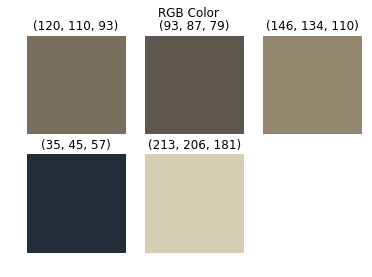

In [33]:
height, width, channels = bar.shape
all_count, top_three = count_color(width, height,bar)
#show_raw_img(bar)
colors = draw_colors(top_three)
#print("image ", height, width,channels)

## find a proper threashold for canny edge (Optional: Did not cover in course)

In [34]:
def nothing(x):
    pass

In [35]:
img_noblur = train_data[1][0]
#img = cv2.blur(img_noblur, (7,7))
gray_img = cv2.cvtColor(img_noblur, cv2.COLOR_BGR2GRAY)   
canny_edge = cv2.Canny(gray_img, 0, 0)
cv2.imshow('org', img_noblur) 
cv2.imshow('gray', gray_img) 
cv2.imshow('canny_edge', canny_edge)
cv2.createTrackbar('min_value','canny_edge',0,500,nothing)
cv2.createTrackbar('max_value','canny_edge',0,500,nothing)
 
while(1):
    cv2.imshow('canny_edge', canny_edge)
    #p_img = cv2.GaussianBlur(canny_edge, (3,3), 0 )  
    #cv2.imshow('after gaussian', p_img)

    min_value = cv2.getTrackbarPos('min_value', 'canny_edge')
    max_value = cv2.getTrackbarPos('max_value', 'canny_edge')
    
    if cv2.waitKey(0) & 0xFF == ord('r'):
        canny_edge = cv2.Canny(gray_img, threshold1=min_value,threshold2=max_value)
        print("set min to ", min_value,  "set max to", max_value)
        
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
    

## generate line mask in GRAY (Optional: Did not cover in course)

In [36]:
def draw_mask_image(img, lines=None):
    nrows, ncolums = img.shape
    canvans = np.zeros((nrows, ncolums, 3), dtype = "uint8")
    canvans = cv2.rectangle(canvans, (int(0), 0), (int(nrows),ncolums),
                               np.array((0,0,0),dtype = "uint8").tolist(), -1)
    return cv2.cvtColor(canvans, cv2.COLOR_BGR2GRAY)

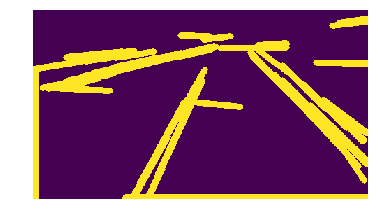

In [37]:
img, action = get_saved_data(1)
new_screen, hlines= detect_edge(img)
mask_img = draw_mask_image(new_screen)
draw_lines(mask_img,hlines)
show_raw_img(mask_img)

In [ ]:
# edge_img,edge_lines = detect_edg

image  270 480 3


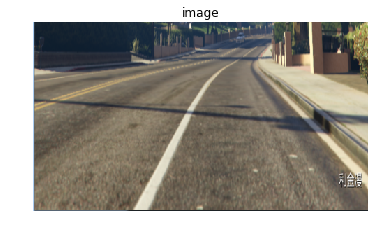

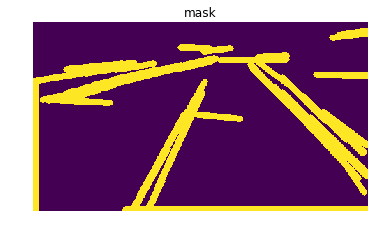

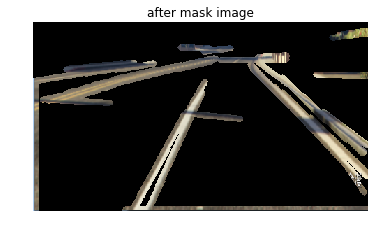

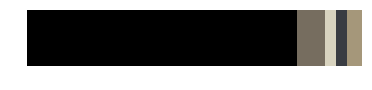

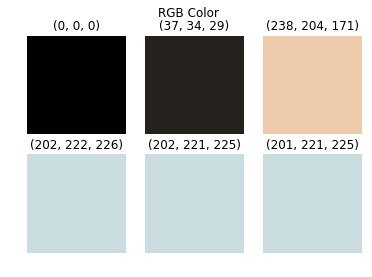

In [38]:
#https://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/
show_rgb_img(img, "image")

ret, mask = cv2.threshold(mask_img, 10, 255, cv2.THRESH_BINARY)
show_raw_img(mask_img, "mask")

img2_fg = cv2.bitwise_and(img,img,mask = mask)

rgb_img = get_rgb_img(img2_fg,"after mask image")

shaped_image = rgb_img.reshape((rgb_img.shape[0] * rgb_img.shape[1], 3))

clt = KMeans(n_clusters = 5)
clt.fit(shaped_image)
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

# show our color bart
show_raw_img(bar)

#try_img=bar
#try_img= try_img.astype(np.uint8)

height, width, channels = rgb_img.shape
print("image ", height, width, channels)
all_count,top_colors = count_color(width, height, img2_fg)
colors = draw_colors(top_colors)

In [39]:
res_yellow=extract_with_yellowBGR(img2_fg)
display_image_win('yellow',res_yellow)
destroy_win()

In [31]:
height

270

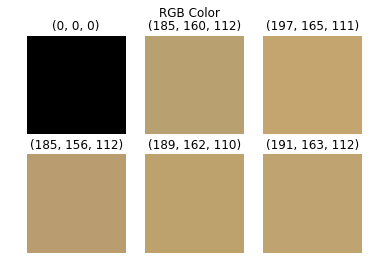

In [32]:
all_count,top_colors = count_color(width, height, res_yellow)
colors = draw_colors_rgb(top_colors)

In [10]:
lines=[[[104, 112, 346, 133]],

       [[129, 269, 479, 269]],

       [[  1, 117,  51, 104]]]
import numpy as np
np.mean(lines,axis=0)[0]

array([  78.        ,  166.        ,  292.        ,  168.66666667])

In [13]:
len(lines)

3

In [18]:
lines_zero = [[[]]]
len(lines_zero[0][0])

0

In [9]:
lines=np.array(lines,dtype=np.float)
lines.shape

(3, 1, 4)

In [69]:
np.mean(line,axis=(0))

array([[ 225.49206349,  122.79365079,  306.3015873 ,  126.17460317]])

In [70]:
np.mean(yellow_edge_line,axis=0)

array([[  26. ,  110.5,  108.5,   91.5]])

In [73]:
yellow_edge_line

array([[[ 26, 110, 112,  90]],

       [[ 26, 111, 105,  93]]], dtype=int32)

In [40]:
lines = yellow_edge_line
min_y = 100
max_y = 200
line_dict={}
new_lines = []
for idx,i in enumerate(lines):
    for xyxy in i:
        # These four lines:
        # modified from http://stackoverflow.com/questions/21565994/method-to-return-the-equation-of-a-straight-line-given-two-points
        # Used to calculate the definition of a line, given two sets of coords.
        x_coords = (xyxy[0],xyxy[2])
        y_coords = (xyxy[1],xyxy[3])
        A = vstack([x_coords,ones(len(x_coords))]).T
        m, b = lstsq(A, y_coords)[0]

        # Calculating our new, and improved, xs
        x1 = (min_y-b) / m
        x2 = (max_y-b) / m

        line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]]
        new_lines.append([int(x1), min_y, int(x2), max_y])


In [78]:
line_dict

{0: [-0.23255813953488394, 116.04651162790695, [68, 100, -360, 200]],
 1: [-0.22784810126582269, 116.9240506329114, [74, 100, -364, 200]]}

## 4. 探测道路分割线 (Find main lanes)

From Section 2. Edge Detection, we can see the output lines are a lot, there are a lot of lines been extracted.

In this section, we want to filter out the noise, just remain the main lanes of the road (regardless of color, i.e. yellow lane/white lane)

In [13]:
def find_main_lanes(img, lines, color=[0, 255, 255], thickness=3,HEIGHT=270):

    # if this fails, go with some default line
    try:
        # finds the maximum y value for a lane marker 
        # (since we cannot assume the horizon will always be at the same point.)

        ys = []  
        for i in lines:
            for ii in i:
                ys += [ii[1],ii[3]]
        #print(lines)
        min_y = min(ys)
        max_y = HEIGHT
        mid_y = 200
        new_lines = []
        line_dict = {}

###################################################################        
#         yellow_lines = find_yellow_lane_BGR(img)
        # yellow_lane is the most important thing
        # 筛两次，把主要的方向筛出来，然后选择相应的线作为lane
        #yellow_lane = np.mean(yellow_edge_line,axis=0)
        #yellow_slope = (yellow_lane[3]-yellow_lane[1])/(yellow_lane[2]-yellow_lane[0])
        # use arctan to find the angle
        # case 1: if we have good yellow lane:
        #     find other lanes with 1.1 angle +_15
        #     find the nearst three lane (how to measure the distance?)
###################################################################        
        
#########Step 1: Convert each input line from lines from format of [x1,y1,x2,y2] to y=mx+b format, and normalize to [x1s,min_y,x2s,max_y]#####################
    #####Note: (x1,y1), and (x2,y2) are two points that defined the line;
               #(x1s,min_y) and (x2s,max_y) are extrapolated points on that line, and min_y and max_y are fixed value for this picture, that's why we called it normalized
        
        for idx,i in enumerate(lines):
            for xyxy in i: #xyxy is [x1,y1,x2,y2] format
                # These four lines:
                # modified from http://stackoverflow.com/questions/21565994/method-to-return-the-equation-of-a-straight-line-given-two-points
                # Used to calculate the definition of a line, given two sets of coords.
                x_coords = (xyxy[0],xyxy[2])
                y_coords = (xyxy[1],xyxy[3])
                A = vstack([x_coords,ones(len(x_coords))]).T
                m, b = lstsq(A, y_coords)[0]

                # Normalize line array to [x1s,min_y,x2s,max_y] based on m and b
                x1 = (min_y-b) / m #x1s
                x2 = (max_y-b) / m #x2s

                line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]]
                new_lines.append([int(x1), min_y, int(x2), max_y])

        final_lanes = {}


#########Step 2: Clustering similar lines to one group, and return group of lines ##########################################
    # Criteria: m (slope) and b (intersection) are similar within 20%, i.e. within range of (self*0.8,self*1.2), 
    # these lines are considered as one group
        for idx in line_dict:
            final_lanes_copy = final_lanes.copy()
            m = line_dict[idx][0]
            b = line_dict[idx][1]
            line = line_dict[idx][2]
            
            if len(final_lanes) == 0:
                final_lanes[m] = [ [m,b,line] ]
                
            else:
                found_copy = False

                for other_ms in final_lanes_copy:
                    if not found_copy:
                        if abs(other_ms*1.2) > abs(m) > abs(other_ms*0.8):
                            if abs(final_lanes_copy[other_ms][0][1]*1.2) > abs(b) > abs(final_lanes_copy[other_ms][0][1]*0.8):
                                final_lanes[other_ms].append([m,b,line])
                                found_copy = True
                                break
                        else:
                            final_lanes[m] = [ [m,b,line] ]

        line_counter = {}

        for lanes in final_lanes:
            line_counter[lanes] = len(final_lanes[lanes])

        top_lanes = sorted(line_counter.items(), key=lambda item: item[1])[::-1][:3]

        #For this function, we only pick top 2 line groups that contain the most number of lines.
        lane1_id = top_lanes[0][0]
        lane2_id = top_lanes[1][0]

        
#########Step 3: For each cluster (group) of lines, calculate the average line that best represents each group###############
    # Method: Calculate mean() of x1,2 value and y1,2 value of all lines in one group, 
        # and get [mean_x1, mean_y1,mean_x2, mean_y2] that represents that group.
        def average_lane(lane_data):
            x1s = []
            y1s = []
            x2s = []
            y2s = []
            for data in lane_data:
                x1s.append(data[2][0])
                y1s.append(data[2][1])
                x2s.append(data[2][2])
                y2s.append(data[2][3])
            return [int(mean(x1s)), int(mean(y1s)), int(mean(x2s)), int(mean(y2s))]

        l1 = average_lane(final_lanes[lane1_id])
        l2 = average_lane(final_lanes[lane2_id])

        return l1,l2
    except Exception as e:
        print(str(e))

In [16]:
# Input lines format: e.g. "([12,23,43,234],[124,223,43,334],...)"
def draw_lines2(img,lines,color=[255,255,255],width=8):
    for coords in lines:
        cv2.line(img, (coords[0], coords[1]), (coords[2], coords[3]), [255,255,255], 8)

[0, 0, 0, 0, 0, 1, 0, 0, 0]
there are 52 lines detected


D:\Program_Data\Anaconda3\envs\py37wanmen\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


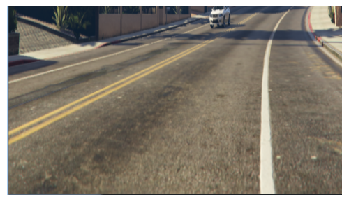

In [18]:
img, action = get_saved_data(13)
show_saved_data(13)
#edge detection, get collections of lines
new_screen, lines= detect_edge(img)
print("there are " + str(lines.shape[0]) + " lines detected") #there are 52 lines detected here
display_image_win('window2',new_screen)
destroy_win()

#find main lanes (only remain 2 main lines from those 52 lines in picture, and those 2 main lines are likely two main lanes on the road)
l1,l2=find_main_lanes(img,lines,1,270)
lines=(l1,l2)
draw_lines2(img,lines) # it will make change on the original lines, but not return any new img
display_image_win('window3',img)
destroy_win()

32.11-13 code not shown here:
- code is mainly about how to interact with game control
- i.e. how to make person in game to walk along the detected lane
- Code is in separate .py files which were not provided